[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ciminilab/2022_Garcia-Fossa_submitted/blob/main/basic_protocol_2/notebook/Basic_Protocol_2.ipynb)

# **Visualize random or representative cell in a given group and field of view**

## Before running, click on **+ Copy to my Drive** to have your own copy of the notebook.

- **What are the inputs necessary to run this notebook?** You don't have to worry if you don't have your own data, you can use an example from our GitHub.

- **What if I wanna run this notebook with my own data?** 
 

1.  Before anything else, you need a table with feature information on the columns, and single-cell information on rows. We recommend to use CellProfiler outputs, since they will be in the same format;
2.   Then you need to mount this notebook on your Google Drive, so it can access your images and table;
3. Don't forget to change the Inputs on Section 2 to match your data's name and path.




        
## Steps:

1. Import libraries
2. Define inputs 
3.a) Import dataset, normalize and feature select and 3.b) Import pre processed dataset
4. Choose the information to plot
5. Calculate correlations
6. Visualize!

  

# **1. Import libraries**

Installing the libraries will take about 5 minutes to run.

In [1]:
#@title Clone GitHub and pip install functions

#@markdown * This step will clone the GitHub repository presented on the Interpreting Image-Based Profiles paper. 


!git clone -b Basic_Protocol_2_ipynb_changes https://github.com/ciminilab/2023_Garcia-Fossa_Cruz_CurrentProtocols

%cd /content/2023_Garcia-Fossa_Cruz_CurrentProtocols/
!pip install ./utils

Cloning into '2023_Garcia-Fossa_Cruz_CurrentProtocols'...
remote: Enumerating objects: 884, done.
remote: Counting objects: 100% (360/360), done.
remote: Compressing objects: 100% (191/191), done.
remote: Total 884 (delta 207), reused 315 (delta 166), pack-reused 524
Receiving objects: 100% (884/884), 572.95 MiB | 13.51 MiB/s, done.
Resolving deltas: 100% (261/261), done.
Updating files: 100% (431/431), done.
/content/2023_Garcia-Fossa_Cruz_CurrentProtocols
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing ./utils
  Preparing metadata (setup.py) ... done
  Created wheel for utils: filename=utils-1.0-py3-none-any.whl size=1037 sha256=6642d075cd1a28e51ea1edd6a230edcc072defde549a946ead777c799d22454f
  Stored in directory: /tmp/pip-ephem-wheel-cache-hp94aosd/wheels/d4/b7/ac/d71b137ac7fe7a91d4bd8cf03d2b29f76a5a07fafde534fffe
Successfully built utils


In [2]:
#@title Pip install needed libraries and import libraries

#@markdown * This step will take about 5 minutes to run.

!pip install pyarrow==9
!pip install git+https://github.com/cytomining/pycytominer
!pip install openpyxl
!pip install scikit-image
!pip install hdmedians
!pip install scikit-fda
!pip install GPy
!pip install matplotlib-scalebar


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/cytomining/pycytominer to /tmp/pip-req-build-u3pol4tf
  Running command git clone --filter=blob:none --quiet https://github.com/cytomining/pycytominer /tmp/pip-req-build-u3pol4tf
  Resolved https://github.com/cytomining/pycytominer to commit b2c6cc4580cf9e1c040a7370b99976916a22e756
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.2/317.2 KB 7.8 MB/s eta 0:00:00
  Created wheel for pycytominer: filename=pycytominer-0.2.0-py2.py3-none-any.whl size=92321 sha256=6e989e7ef626c003ceb957b6d74fc877051c68ffe0fad5dea3497d3721a6fbc8
  Stored in directory: /tmp/pip-ephem-wheel-cache-7szql0tp/wheels/d3/df/7d/89e6e01e8873d412b22695a6ed7b4983fb68583f62425dc6c2
Successfully built pycytominer
  Attempting uninstall: pluggy
    Found existi

In [3]:
#@title Import libraries

%matplotlib notebook
%matplotlib inline
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from utils.read_data import *
from utils.visualize_data import *
from utils.correlations import *
from sklearn.cluster import KMeans
from openpyxl import Workbook, load_workbook
import os
import pycytominer
from google.colab import files
from matplotlib_scalebar.scalebar import ScaleBar
import ipywidgets as widgets

# **2. Define inputs**



* Here we define the file_name, dataset_path and images_dir based on the path we have on our GitHub repository.

    -  **profile_filename** - provide the name for your profiles dataset. Please provide the filename with extension, e.g. **Profiles.csv**  (check supported formats in [pandas documentation](https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html));
    -  **dataset_path** - path to your profiles dataset (file_name above);
    -  **images_dir** - root directory to the images (can be our GitHub repo or your local directory to test with your own images);
    - **metadata_dir and metadata_file**: if using external file to annotate your dataset, answer yes and provide the path and filename for metadata file;
    -  **box_size** - size of box in pixels for cropping a cell. 150 is a good start.
    -  **channels** - list of channels you want to plot, separated by space (i.e., DNA ER AGP);
    - **FileName_**: prefix of the FileName column contained in your dataset. If it's an output from CellProfiler, it would start with FileName_ and could have an additional prefix common to all channels (for example, FileName_OrigDNA, FileName_OrigER, so you should enter FileName_Orig as the prefix). 
    - **image_width_column**: provide the full name for one of the columns that contains the Width of the image (usually this would be equal for all of the images on your dataset), so just choose one. For example: Width_OrigDNA. 
    - **compressed_images new size and format**: did you analyzed your images on the original ones, and now will use compressed images to plot the single-cells? So answer yes to the compressed question, and provide the file extension.
    - 



In [48]:
#@title If running using the **example from our GitHub repository**, run this cell to define the inputs.

file_name =  r"/BasicProtocols2_Example_Raw.zip"

dataset_path = r"/content/2023_Garcia-Fossa_Cruz_CurrentProtocols/basic_protocol_2/data"

images_dir = r"/content/2023_Garcia-Fossa_Cruz_CurrentProtocols/basic_protocol_2/images" #give the directory of where pictures are

metadata_dir = r"/content/2023_Garcia-Fossa_Cruz_CurrentProtocols/basic_protocol_2/metadata"

metadata_file = r"/metadata.csv"

box_size = 150

channels = ["DNA","ER","RNA","AGP","Mito"]

filename_col_prefix = "Image_FileName_Orig"

image_width_column = "Image_Width_OrigDNA"

compressed_images = True

compressed_size = 1080

compressed_format = 'png'

In [5]:
#@title Run this cell to answer about the number of plates. For the demo from GitHub repo, write no and press enter. 
dir_unique_input = input("Do you have images from more than one plate inside this dataset? Type yes or no and hit enter ")
dir_unique = stringToBool(dir_unique_input)

if dir_unique:
  print('Please select the column that has information about the plates (labels, etc). Be aware that this information should also be available somewhere on your image path!')
  print('Having the plate names somewhere (filename of your images, name of your folder) will help determine where the image is located to plot it.')
  df_temp = pd.read_csv(dataset_path+file_name, low_memory=False)
  df_list = [option for option in df_temp.columns]
  plate_choice = widgets.Dropdown(
    options=df_list,
    description='Choose:',
    disabled=False)
  display(plate_choice)
else:
  dir_unique_col = None

Do you have images from more than one plate inside this dataset? Type yes or no and hit enter no


In [ ]:
#@title Run this cell only if you want to **run with your own data** instead the ones in our GitHub repo.

#@markdown * This cell will mount Colab on your own Google Drive, and ask for the inputs.

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

file_name_input =  input(r"Provide file_name with the extension (.csv):")
file_name = "/" + file_name_input

dataset_path_input = input(r"Provide the path to file_name:")
dataset_path = dataset_path_input

images_dir_input = input(r"Provide the path to your images:")
images_dir = images_dir_input

metadata_question = input(r"If you need to annotate your dataset with an external file, write yes and press enter. If already annotated, answer no and press enter.")
metadata_answer = stringToBool(metadata_question)

if metadata_answer:
  metadata_dir_input = input(r"Provide the path to your metadata file:")
  metadata_dir = metadata_dir_input

  metadata_file_input = input(r"Provide the filename to your metadata file with the extension (.csv):")
  metadata_file = metadata_file_input

channels = [item for item in input("Provide a list of names for the channels you want to plot. Give them separated by space like: DNA RNA ER ").split()]

box_size_input = input("Size of the box to crop the cells, in pixels. A good start is 150 pixels: ")
box_size = int(box_size_input)

filename_col_prefix_input = input("Paste the FileName prefix here, i.e. FileName_: ")
filename_col_prefix = filename_col_prefix_input

image_width_column_input = input("Paste one of the Width columns (full name) here, i.e. Width_DNA: ")
image_width_column = image_width_column_input

compressed_images_input = input("Are you plotting images that are compressed in a png, jpeg format? Answer yes or no ")
compressed_images = stringToBool(compressed_images_input)

if compressed_images:
  compressed_size_input = input("Provide the size for the compressed image: ")
  compressed_size = int(compressed_size_input)
  compressed_format_input = input("What's the image file format? Could be png, jpeg ")
  compressed_format = compressed_format_input
else:
  compressed_size = None
  compressed_format = None

# **3a. Import dataset, normalize and feature select**

- To import raw data and normalize and feature select it, run this section
- Run this section to demo our notebook.

In [6]:
#@title **3a1. Import dataset**

df = pd.read_csv(dataset_path+file_name, low_memory=False)

In [7]:
#@title **3a2. Metadata import and annotate dataset - if having metadata already, SKIP THIS STEP**

metadata = pd.read_csv(metadata_dir+metadata_file, low_memory=False)

In [8]:
#@title Annotate dataset using pycytominer

df = pycytominer.annotate(profiles = df, platemap = metadata, join_on =  ["Metadata_Well", "Image_Metadata_Well"])

## **3a3. Normalization steps**

1. We select a few columns' names we want to keep related to Metadata and Image_Filename
2. We retrieve 'Nuclei_Location_Center_X' and 'Nuclei_Location_Center_Y' columns to NOT be normalized during this process, and add it again later
3. Choose negative control to normalize to
4. Answer wheter there's more than one plate in this dataset, if yes, choose the column with the plate information
5. Normalize using mad_robustize

For more information on normalization by pycytominer and other methods, see their [documentation](https://pycytominer.readthedocs.io/en/latest/)

In [9]:
#@title **Select a few columns to keep before normalization**
list_cols = ['Metadata_', 'Image_FileName_Orig', 'Image_Width_OrigDNA']
cols_keep = []
for cols in df.columns:
  for items in list_cols:
    if cols.startswith(items):
      cols_keep.append(cols)
print(cols_keep)

#keep location columns elsewhere and drop them from df
df_loc = df[['Nuclei_Location_Center_X', 'Nuclei_Location_Center_Y']]
df = df.drop(columns=['Nuclei_Location_Center_X', 'Nuclei_Location_Center_Y'])

['Metadata_Concentration', 'Metadata_moa', 'Metadata_Compound', 'Metadata_Plate', 'Metadata_Well', 'Image_FileName_OrigAGP', 'Image_FileName_OrigDNA', 'Image_FileName_OrigER', 'Image_FileName_OrigMito', 'Image_FileName_OrigRNA', 'Image_Width_OrigDNA']


In [10]:
#@title Please run to activate dropdown function
def dropdown(input_list):
  import ipywidgets as widgets
  global dropdown_output
  drop_down = widgets.Dropdown(options=input_list,
                                  description='Choose',
                                  disabled=False)

  def dropdown_handler(change):
      global dropdown_output
      dropdown_output = change.new  # This line isn't working
  drop_down.observe(dropdown_handler, names='value')
  display(drop_down)
  dropdown_output = drop_down.value


In [11]:
#@title Choose a label column where your **negative control** is. Please choose **"Metadata_Compound"** for this demo
df_list = [option for option in df.filter(regex=r'Metadata', axis=1).columns]
dropdown(df_list)

Dropdown(description='Choose', options=('Metadata_Concentration', 'Metadata_moa', 'Metadata_Compound', 'Metada…

In [12]:
#@title Save dropdown choice

sort_by_neg = dropdown_output
print(sort_by_neg)

Metadata_Compound


In [13]:
#@title Choose the **negative control**. Please select **DMSO** for this demo

df_list = [option for option in df[sort_by_neg].unique().tolist()]
dropdown(df_list)

Dropdown(description='Choose', options=('DMSO', 'XL888', 'ixabepilone', 'LY2334737', 'docetaxel', 'cabazitaxel…

In [14]:
#@title Save selected compound
neg_ctrl = dropdown_output
print(neg_ctrl)

DMSO


In [15]:
#@title Is there more than one plate in this dataset? If yes, choose the column where plate information is. 
#@markdown - Be aware that when having more than one plate, the normalization will be performed on a per-plate basis. 
if dir_unique:
  print("Please select the column that has the plates' names")
  df_list = [option for option in df.columns]
  plate_selection = widgets.Dropdown(
    options=df_list,
    description='Choose:',
    disabled=False)
  display(plate_selection)
else:
  print('You have answered no to having multiple plates above, so proceed with normalization.')

You have answered no to having multiple plates above, so proceed with normalization.


## Choose A) to normalize to negative control or B) to normalize by the whole plate.

IMPORTANT: You should choose either A or B. (A) will get the negative control selected above and normalize each feature relative to control, and (B) will just normalize each feature. Read more about [normalization here](https://carpenter-singh-lab.broadinstitute.org/blog/how-normalize-cell-painting-data).

In [16]:
#@title **A) Normalize the dataset to negative control**
neg_term = "'%s'" % neg_ctrl #add quotes to chosen compound/selection
sample = f"{sort_by_neg + '==' + neg_term}"

if dir_unique:
  plate_column = plate_selection.value
  plates = df[plate_column].unique().tolist()
  df_temp_list = []
  for pl in plates:
    df_temp = df[df[plate_column] == pl]
    print('Shape of each plate dataframe', df_temp.shape)
    df_temp2 = pycytominer.normalize(df_temp, meta_features = cols_keep, samples = sample, method='mad_robustize', mad_robustize_epsilon = 0)
    df_temp_list.append(df_temp2)
  df_norm2 = pd.concat(df_temp_list, axis=0)

else:
  df_norm2 = pycytominer.normalize(df, meta_features = cols_keep, samples = sample, method='mad_robustize', mad_robustize_epsilon = 0)

In [ ]:
#@title **B) OR normalize per-plate to all**

if dir_unique:
  plate_column = plate_selection.value
  plates = df[plate_column].unique().tolist()
  df_temp_list = []
  for pl in plates:
    df_temp = df[df[plate_column] == pl]
    print('Shape of each plate dataframe', df_temp.shape)
    df_temp2 = pycytominer.normalize(df, meta_features = cols_keep, method='mad_robustize', mad_robustize_epsilon = 0)
    df_temp_list.append(df_temp2)
  df_norm2 = pd.concat(df_temp_list, axis=0)

df_norm2 = pycytominer.normalize(df, meta_features = cols_keep, method='mad_robustize', mad_robustize_epsilon = 0)

## **3a4. Feature Selection**

- Perform feature selection using 'correlation_threshold', 'variance_threshold', 'drop_na_columns', 'blocklist', and 'drop_outliers' methods.

For more information on feature selection by pycytominer and other methods, see their [documentation](https://pycytominer.readthedocs.io/en/latest/)

In [17]:
#@title Run to perform feature selection

#@markdown This step might take about 2-5 minutes depending on the DataFrame size.
df_selected = pycytominer.feature_select(df_norm2, operation = ['correlation_threshold', 'variance_threshold', 'drop_na_columns', 'blocklist','drop_outliers'])
print('Number of columns removed:', df.shape[1] - df_selected.shape[1])

Number of columns removed: 1665


In [18]:
#@title **Join back Nuclei_Location columns**
df = pd.concat([df_selected, df_loc], axis = 1)

## **3a5. Create new column: join Compound + Concentration**
*   This will make it easier later if the user wants to plot compounds that has more than one tested concentration


In [19]:
col_generator(df, cols_to_join = ['Metadata_Compound', 'Metadata_Concentration'])

Concentration
Names of the compounds + concentration:  ['DMSO 0.0' 'XL888 10.0' 'ixabepilone 10.0' 'LY2334737 10.0'
 'LY2334737 1.111111111' 'docetaxel 10.0' 'cabazitaxel 10.0'
 'fiacitabine 10.0']


,Metadata_Concentration,Metadata_moa,Metadata_Compound,Metadata_Plate,Metadata_Well,Image_FileName_OrigAGP,Image_FileName_OrigDNA,Image_FileName_OrigER,Image_FileName_OrigMito,Image_FileName_OrigRNA,...,Nuclei_Texture_SumVariance_RNA_20_0,Nuclei_Texture_Variance_AGP_20_0,Nuclei_Texture_Variance_DNA_20_0,Nuclei_Texture_Variance_ER_20_0,Nuclei_Texture_Variance_Mito_20_0,Nuclei_Texture_Variance_RNA_10_0,Nuclei_Texture_Variance_RNA_20_0,Nuclei_Location_Center_X,Nuclei_Location_Center_Y,Metadata_Compound_Concentration
0,0.0,DMSO,DMSO,SQ00015195,A02,r01c02f01p01-ch4sk1fk1fl1.tiff,r01c02f01p01-ch1sk1fk1fl1.tiff,r01c02f01p01-ch2sk1fk1fl1.tiff,r01c02f01p01-ch5sk1fk1fl1.tiff,r01c02f01p01-ch3sk1fk1fl1.tiff,...,0.037994,0.213458,0.220092,0.475223,0.204038,-0.230087,0.035018,653.073964,32.750634,DMSO 0.0
1,0.0,DMSO,DMSO,SQ00015195,A02,r01c02f01p01-ch4sk1fk1fl1.tiff,r01c02f01p01-ch1sk1fk1fl1.tiff,r01c02f01p01-ch2sk1fk1fl1.tiff,r01c02f01p01-ch5sk1fk1fl1.tiff,r01c02f01p01-ch3sk1fk1fl1.tiff,...,-0.397309,-0.120852,1.905764,-0.150426,0.768826,0.265255,0.409967,1979.191781,47.390839,DMSO 0.0
2,0.0,DMSO,DMSO,SQ00015195,A02,r01c02f01p01-ch4sk1fk1fl1.tiff,r01c02f01p01-ch1sk1fk1fl1.tiff,r01c02f01p01-ch2sk1fk1fl1.tiff,r01c02f01p01-ch5sk1fk1fl1.tiff,r01c02f01p01-ch3sk1fk1fl1.tiff,...,-0.592361,-1.039545,0.514831,-0.770675,-0.574780,-0.569374,-0.445787,2080.545903,48.469193,DMSO 0.0
3,0.0,DMSO,DMSO,SQ00015195,A02,r01c02f01p01-ch4sk1fk1fl1.tiff,r01c02f01p01-ch1sk1fk1fl1.tiff,r01c02f01p01-ch2sk1fk1fl1.tiff,r01c02f01p01-ch5sk1fk1fl1.tiff,r01c02f01p01-ch3sk1fk1fl1.tiff,...,0.351370,0.056879,0.067970,-0.750939,-0.117725,0.188915,0.462832,1120.825549,52.805403,DMSO 0.0
4,0.0,DMSO,DMSO,SQ00015195,A02,r01c02f01p01-ch4sk1fk1fl1.tiff,r01c02f01p01-ch1sk1fk1fl1.tiff,r01c02f01p01-ch2sk1fk1fl1.tiff,r01c02f01p01-ch5sk1fk1fl1.tiff,r01c02f01p01-ch3sk1fk1fl1.tiff,...,0.340218,0.214775,-0.120186,0.799046,0.821123,0.209767,0.088538,1696.844459,78.116332,DMSO 0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7572,10.0,DNA synthesis inhibitor,fiacitabine,SQ00015195,L19,r12c19f09p01-ch4sk1fk1fl1.tiff,r12c19f09p01-ch1sk1fk1fl1.tiff,r12c19f09p01-ch2sk1fk1fl1.tiff,r12c19f09p01-ch5sk1fk1fl1.tiff,r12c19f09p01-ch3sk1fk1fl1.tiff,...,-0.782877,1.320061,-2.053162,0.468402,-0.893960,-1.721692,-1.411222,257.289705,2091.924182,fiacitabine 10.0
7573,10.0,DNA synthesis inhibitor,fiacitabine,SQ00015195,L19,r12c19f09p01-ch4sk1fk1fl1.tiff,r12c19f09p01-ch1sk1fk1fl1.tiff,r12c19f09p01-ch2sk1fk1fl1.tiff,r12c19f09p01-ch5sk1fk1fl1.tiff,r12c19f09p01-ch3sk1fk1fl1.tiff,...,2.484337,1.914382,-0.777660,0.448338,0.024980,0.500579,0.413282,1040.821322,2097.956493,fiacitabine 10.0
7574,10.0,DNA synthesis inhibitor,fiacitabine,SQ00015195,L19,r12c19f09p01-ch4sk1fk1fl1.tiff,r12c19f09p01-ch1sk1fk1fl1.tiff,r12c19f09p01-ch2sk1fk1fl1.tiff,r12c19f09p01-ch5sk1fk1fl1.tiff,r12c19f09p01-ch3sk1fk1fl1.tiff,...,1.731343,0.957946,-2.608285,1.336558,-0.134796,1.604849,0.958992,1429.728495,2098.826344,fiacitabine 10.0
7575,10.0,DNA synthesis inhibitor,fiacitabine,SQ00015195,L19,r12c19f09p01-ch4sk1fk1fl1.tiff,r12c19f09p01-ch1sk1fk1fl1.tiff,r12c19f09p01-ch2sk1fk1fl1.tiff,r12c19f09p01-ch5sk1fk1fl1.tiff,r12c19f09p01-ch3sk1fk1fl1.tiff,...,1.362378,0.058719,-1.027053,-0.726884,0.575325,0.150917,0.569167,1743.008311,2110.983646,fiacitabine 10.0


# **3b. Import dataset pre-processed**

- Import data here that was already normalized and feature selected elsewhere (for example using the [notebook on GH repo](https://github.com/ciminilab/2022_Garcia-Fossa_submitted/blob/main/basic_protocol_2/notebook/support%20notebooks/2_Generate_Profiles.ipynb))

In [ ]:
#open DataFrame
df = pd.read_csv(dataset_path+file_name, low_memory=False)

## **3.1 Create new column: join Compound + Concentration**
*   This will make it easier later if the user wants to plot compounds that has more than one tested concentration


In [ ]:
col_generator(df, cols_to_join = ['Metadata_Compound', 'Metadata_Concentration'])

Names of the compounds + concentration:  ['DMSO 0.00' 'XL888 10.00' 'ixabepilone 10.00' 'LY2334737 10.00'
 'LY2334737 1.11' 'docetaxel 10.00' 'cabazitaxel 10.00'
 'fiacitabine 10.00']


,Metadata_Plate,Image_FileName_OrigAGP,Image_FileName_OrigDNA,Image_FileName_OrigER,Image_FileName_OrigMito,Image_FileName_OrigRNA,Metadata_Well,Metadata_Concentration,Metadata_moa,Metadata_Compound,...,Nuclei_Texture_SumVariance_RNA_20_0,Nuclei_Texture_Variance_AGP_20_0,Nuclei_Texture_Variance_DNA_20_0,Nuclei_Texture_Variance_ER_20_0,Nuclei_Texture_Variance_Mito_20_0,Nuclei_Texture_Variance_RNA_10_0,Nuclei_Texture_Variance_RNA_20_0,Nuclei_Location_Center_X,Nuclei_Location_Center_Y,Metadata_Compound_Concentration
0,SQ00015195,r01c02f01p01-ch4sk1fk1fl1.tiff,r01c02f01p01-ch1sk1fk1fl1.tiff,r01c02f01p01-ch2sk1fk1fl1.tiff,r01c02f01p01-ch5sk1fk1fl1.tiff,r01c02f01p01-ch3sk1fk1fl1.tiff,A02,0.00,DMSO,DMSO,...,0.037994,0.213458,0.220092,0.475223,0.204038,-0.230087,0.035018,653.073964,32.750634,DMSO 0.00
1,SQ00015195,r01c02f01p01-ch4sk1fk1fl1.tiff,r01c02f01p01-ch1sk1fk1fl1.tiff,r01c02f01p01-ch2sk1fk1fl1.tiff,r01c02f01p01-ch5sk1fk1fl1.tiff,r01c02f01p01-ch3sk1fk1fl1.tiff,A02,0.00,DMSO,DMSO,...,-0.397309,-0.120852,1.905764,-0.150426,0.768826,0.265255,0.409967,1979.191781,47.390839,DMSO 0.00
2,SQ00015195,r01c02f01p01-ch4sk1fk1fl1.tiff,r01c02f01p01-ch1sk1fk1fl1.tiff,r01c02f01p01-ch2sk1fk1fl1.tiff,r01c02f01p01-ch5sk1fk1fl1.tiff,r01c02f01p01-ch3sk1fk1fl1.tiff,A02,0.00,DMSO,DMSO,...,-0.592361,-1.039545,0.514831,-0.770675,-0.574780,-0.569374,-0.445787,2080.545903,48.469193,DMSO 0.00
3,SQ00015195,r01c02f01p01-ch4sk1fk1fl1.tiff,r01c02f01p01-ch1sk1fk1fl1.tiff,r01c02f01p01-ch2sk1fk1fl1.tiff,r01c02f01p01-ch5sk1fk1fl1.tiff,r01c02f01p01-ch3sk1fk1fl1.tiff,A02,0.00,DMSO,DMSO,...,0.351370,0.056879,0.067970,-0.750939,-0.117725,0.188915,0.462832,1120.825549,52.805403,DMSO 0.00
4,SQ00015195,r01c02f01p01-ch4sk1fk1fl1.tiff,r01c02f01p01-ch1sk1fk1fl1.tiff,r01c02f01p01-ch2sk1fk1fl1.tiff,r01c02f01p01-ch5sk1fk1fl1.tiff,r01c02f01p01-ch3sk1fk1fl1.tiff,A02,0.00,DMSO,DMSO,...,0.340218,0.214775,-0.120186,0.799046,0.821123,0.209767,0.088538,1696.844459,78.116332,DMSO 0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7572,SQ00015195,r12c19f09p01-ch4sk1fk1fl1.tiff,r12c19f09p01-ch1sk1fk1fl1.tiff,r12c19f09p01-ch2sk1fk1fl1.tiff,r12c19f09p01-ch5sk1fk1fl1.tiff,r12c19f09p01-ch3sk1fk1fl1.tiff,L19,10.00,DNA synthesis inhibitor,fiacitabine,...,-0.782877,1.320061,-2.053162,0.468402,-0.893960,-1.721692,-1.411222,257.289705,2091.924182,fiacitabine 10.00
7573,SQ00015195,r12c19f09p01-ch4sk1fk1fl1.tiff,r12c19f09p01-ch1sk1fk1fl1.tiff,r12c19f09p01-ch2sk1fk1fl1.tiff,r12c19f09p01-ch5sk1fk1fl1.tiff,r12c19f09p01-ch3sk1fk1fl1.tiff,L19,10.00,DNA synthesis inhibitor,fiacitabine,...,2.484337,1.914382,-0.777660,0.448338,0.024980,0.500579,0.413282,1040.821322,2097.956493,fiacitabine 10.00
7574,SQ00015195,r12c19f09p01-ch4sk1fk1fl1.tiff,r12c19f09p01-ch1sk1fk1fl1.tiff,r12c19f09p01-ch2sk1fk1fl1.tiff,r12c19f09p01-ch5sk1fk1fl1.tiff,r12c19f09p01-ch3sk1fk1fl1.tiff,L19,10.00,DNA synthesis inhibitor,fiacitabine,...,1.731343,0.957946,-2.608285,1.336558,-0.134796,1.604849,0.958992,1429.728495,2098.826344,fiacitabine 10.00
7575,SQ00015195,r12c19f09p01-ch4sk1fk1fl1.tiff,r12c19f09p01-ch1sk1fk1fl1.tiff,r12c19f09p01-ch2sk1fk1fl1.tiff,r12c19f09p01-ch5sk1fk1fl1.tiff,r12c19f09p01-ch3sk1fk1fl1.tiff,L19,10.00,DNA synthesis inhibitor,fiacitabine,...,1.362378,0.058719,-1.027053,-0.726884,0.575325,0.150917,0.569167,1743.008311,2110.983646,fiacitabine 10.00


# **4. User's choice: choose to plot based on which metadata information**



*   You can plot all samples (4.2) or choose to plot a few selected ones (4.3)



In [20]:
#@title Please run to activate dropdown function
def dropdown(input_list):
  import ipywidgets as widgets
  global dropdown_output
  drop_down = widgets.Dropdown(options=input_list,
                                  description='Choose',
                                  disabled=False)

  def dropdown_handler(change):
      global dropdown_output
      dropdown_output = change.new  # This line isn't working
  drop_down.observe(dropdown_handler, names='value')
  display(drop_down)
  dropdown_output = drop_down.value


In [21]:
#@title 4.1 Choose metadata information
df_list = [option for option in df.filter(regex=r'Metadata', axis=1).columns]
dropdown(df_list)

Dropdown(description='Choose', options=('Metadata_Concentration', 'Metadata_moa', 'Metadata_Compound', 'Metada…

In [22]:
#@title 4.1.1 Save dropdown choice

sort_by = dropdown_output
print(sort_by)

Metadata_Compound_Concentration


In [26]:
#@title 4.2 To plot ALL samples or treatments, run this cell


list_to_plot = [x for x in df[sort_by].unique().tolist()]

In [23]:
#@title 4.3 To plot SELECTED choices (samples or treatments), run this cell
import ipywidgets as wid
options_dict = {
    x: wid.Checkbox(
        description=x, 
        value=False,
        style={"description_width":"0px"}
    ) for x in [x for x in df[sort_by].unique().tolist()]
}
ui = multi_checkbox_widget(options_dict)
out = wid.interactive_output(f, options_dict)
display(wid.HBox([ui, out]))

Output()

In [24]:
#@title 4.3.1 Save SELECTED choices
list_to_plot = [widget.description for widget in ui.children[1].children if widget.value]
print(list_to_plot)

['XL888 10.0', 'DMSO 0.0', 'ixabepilone 10.0']


# **5. Calculate correlations**


* These are correlations calculated just as we see on Morpheus.
*   Using corr function, calculate Pearson correlation between the groups.  
*   In the first step, the data is annotated by Well using pycytominer functions (pycytominer_operations), and then visualize confusion matrix using seaborn.

In [25]:
#@title Please run to activate dropdown function
def dropdown(input_list):
  import ipywidgets as widgets
  global dropdown_output
  drop_down = widgets.Dropdown(options=input_list,
                                  description='Choose',
                                  disabled=False)

  def dropdown_handler(change):
      global dropdown_output
      dropdown_output = change.new  # This line isn't working
  drop_down.observe(dropdown_handler, names='value')
  display(drop_down)
  dropdown_output = drop_down.value


In [26]:
#@title Choose **labels** for correlation matrix
df_list = [option for option in df.filter(regex=r'Metadata', axis=1).columns]
dropdown(df_list)

Dropdown(description='Choose', options=('Metadata_Concentration', 'Metadata_moa', 'Metadata_Compound', 'Metada…

In [27]:
#@title Aggregate data by Well
sort_by_corr = dropdown_output
df_corr = df.drop(columns=['Nuclei_Location_Center_X', 'Nuclei_Location_Center_Y'])
df_ag = pycytominer.aggregate(df_corr, strata = sort_by_corr, operation = 'mean')

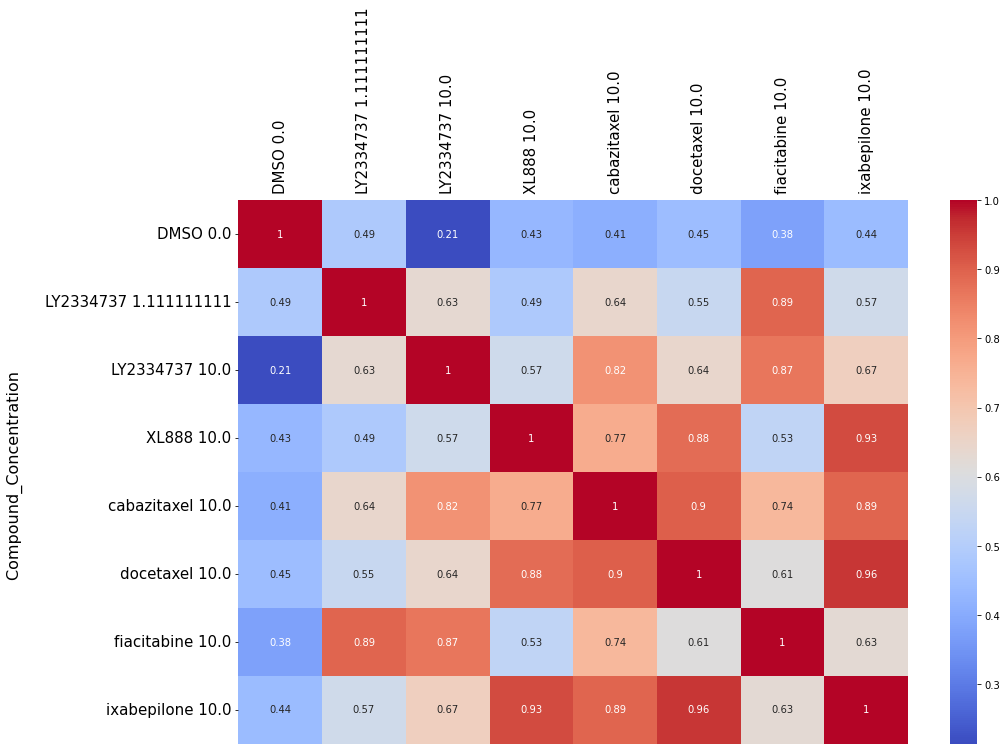

In [28]:
#@title Calculate correlations and plot similarity matrix
corr = corr_calculator(df_ag, strata = sort_by_corr)
corr_fig = plot_corr(corr, fig_size = (15, 10))

In [ ]:
#@title Save correlations plot
fname = input("Give this figure a name:")
img_format = ".png"
corr_fig.figure.savefig(fname+img_format, dpi = 200,  bbox_inches='tight')
files.download(fname+img_format)

Give this figure a name:x


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **5.1 Add correlations to DataFrame**



*   To allow the correlation value to determine the order in which we plot the images, we must add correlation values to the DataFrame.

In [29]:
#@title Correlation based on which sample?

#@markdown * We need to select which sample or treatment we want to have as a point of reference. 

#@markdown * Do you want to see how closely related are the treated cells in reference to a sample? Choose any sample you wish.
df_list = [option for option in df[sort_by].unique().tolist()]
dropdown(df_list)

Dropdown(description='Choose', options=('DMSO 0.0', 'XL888 10.0', 'ixabepilone 10.0', 'LY2334737 10.0', 'LY233…

In [30]:
#@title Save selected sample
corr_to = dropdown_output
print(corr_to)

DMSO 0.0


In [31]:
#@title Insert correlation values to the DataFrame based on your choice
insert_corr(df, corr, corr_to = corr_to, sort_by = sort_by)

{'DMSO 0.0': 1.0, 'LY2334737 1.111111111': 0.4858966482065006, 'LY2334737 10.0': 0.21375641974772022, 'XL888 10.0': 0.4288223083678236, 'cabazitaxel 10.0': 0.40867245282484527, 'docetaxel 10.0': 0.4463960310503926, 'fiacitabine 10.0': 0.37939396300999434, 'ixabepilone 10.0': 0.44384020220007264}


,Metadata_Concentration,Metadata_moa,Metadata_Compound,Metadata_Plate,Metadata_Well,Image_FileName_OrigAGP,Image_FileName_OrigDNA,Image_FileName_OrigER,Image_FileName_OrigMito,Image_FileName_OrigRNA,...,Nuclei_Texture_Variance_AGP_20_0,Nuclei_Texture_Variance_DNA_20_0,Nuclei_Texture_Variance_ER_20_0,Nuclei_Texture_Variance_Mito_20_0,Nuclei_Texture_Variance_RNA_10_0,Nuclei_Texture_Variance_RNA_20_0,Nuclei_Location_Center_X,Nuclei_Location_Center_Y,Metadata_Compound_Concentration,Correlation_to
0,0.0,DMSO,DMSO,SQ00015195,A02,r01c02f01p01-ch4sk1fk1fl1.tiff,r01c02f01p01-ch1sk1fk1fl1.tiff,r01c02f01p01-ch2sk1fk1fl1.tiff,r01c02f01p01-ch5sk1fk1fl1.tiff,r01c02f01p01-ch3sk1fk1fl1.tiff,...,0.213458,0.220092,0.475223,0.204038,-0.230087,0.035018,653.073964,32.750634,DMSO 0.0,1.00
1,0.0,DMSO,DMSO,SQ00015195,A02,r01c02f01p01-ch4sk1fk1fl1.tiff,r01c02f01p01-ch1sk1fk1fl1.tiff,r01c02f01p01-ch2sk1fk1fl1.tiff,r01c02f01p01-ch5sk1fk1fl1.tiff,r01c02f01p01-ch3sk1fk1fl1.tiff,...,-0.120852,1.905764,-0.150426,0.768826,0.265255,0.409967,1979.191781,47.390839,DMSO 0.0,1.00
2,0.0,DMSO,DMSO,SQ00015195,A02,r01c02f01p01-ch4sk1fk1fl1.tiff,r01c02f01p01-ch1sk1fk1fl1.tiff,r01c02f01p01-ch2sk1fk1fl1.tiff,r01c02f01p01-ch5sk1fk1fl1.tiff,r01c02f01p01-ch3sk1fk1fl1.tiff,...,-1.039545,0.514831,-0.770675,-0.574780,-0.569374,-0.445787,2080.545903,48.469193,DMSO 0.0,1.00
3,0.0,DMSO,DMSO,SQ00015195,A02,r01c02f01p01-ch4sk1fk1fl1.tiff,r01c02f01p01-ch1sk1fk1fl1.tiff,r01c02f01p01-ch2sk1fk1fl1.tiff,r01c02f01p01-ch5sk1fk1fl1.tiff,r01c02f01p01-ch3sk1fk1fl1.tiff,...,0.056879,0.067970,-0.750939,-0.117725,0.188915,0.462832,1120.825549,52.805403,DMSO 0.0,1.00
4,0.0,DMSO,DMSO,SQ00015195,A02,r01c02f01p01-ch4sk1fk1fl1.tiff,r01c02f01p01-ch1sk1fk1fl1.tiff,r01c02f01p01-ch2sk1fk1fl1.tiff,r01c02f01p01-ch5sk1fk1fl1.tiff,r01c02f01p01-ch3sk1fk1fl1.tiff,...,0.214775,-0.120186,0.799046,0.821123,0.209767,0.088538,1696.844459,78.116332,DMSO 0.0,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7572,10.0,DNA synthesis inhibitor,fiacitabine,SQ00015195,L19,r12c19f09p01-ch4sk1fk1fl1.tiff,r12c19f09p01-ch1sk1fk1fl1.tiff,r12c19f09p01-ch2sk1fk1fl1.tiff,r12c19f09p01-ch5sk1fk1fl1.tiff,r12c19f09p01-ch3sk1fk1fl1.tiff,...,1.320061,-2.053162,0.468402,-0.893960,-1.721692,-1.411222,257.289705,2091.924182,fiacitabine 10.0,0.38
7573,10.0,DNA synthesis inhibitor,fiacitabine,SQ00015195,L19,r12c19f09p01-ch4sk1fk1fl1.tiff,r12c19f09p01-ch1sk1fk1fl1.tiff,r12c19f09p01-ch2sk1fk1fl1.tiff,r12c19f09p01-ch5sk1fk1fl1.tiff,r12c19f09p01-ch3sk1fk1fl1.tiff,...,1.914382,-0.777660,0.448338,0.024980,0.500579,0.413282,1040.821322,2097.956493,fiacitabine 10.0,0.38
7574,10.0,DNA synthesis inhibitor,fiacitabine,SQ00015195,L19,r12c19f09p01-ch4sk1fk1fl1.tiff,r12c19f09p01-ch1sk1fk1fl1.tiff,r12c19f09p01-ch2sk1fk1fl1.tiff,r12c19f09p01-ch5sk1fk1fl1.tiff,r12c19f09p01-ch3sk1fk1fl1.tiff,...,0.957946,-2.608285,1.336558,-0.134796,1.604849,0.958992,1429.728495,2098.826344,fiacitabine 10.0,0.38
7575,10.0,DNA synthesis inhibitor,fiacitabine,SQ00015195,L19,r12c19f09p01-ch4sk1fk1fl1.tiff,r12c19f09p01-ch1sk1fk1fl1.tiff,r12c19f09p01-ch2sk1fk1fl1.tiff,r12c19f09p01-ch5sk1fk1fl1.tiff,r12c19f09p01-ch3sk1fk1fl1.tiff,...,0.058719,-1.027053,-0.726884,0.575325,0.150917,0.569167,1743.008311,2110.983646,fiacitabine 10.0,0.38


## **5.2 What are the five samples closer to the negative control?**

- We are evaluating the most correlated treatments to the negative control, but you could choose any sample you'd like.

In [32]:
#@title Run dropdown function
def dropdown(input_list):
  import ipywidgets as widgets
  global dropdown_output
  drop_down = widgets.Dropdown(options=input_list,
                                  description='Choose',
                                  disabled=False)

  def dropdown_handler(change):
      global dropdown_output
      dropdown_output = change.new  # This line isn't working
  drop_down.observe(dropdown_handler, names='value')
  display(drop_down)
  dropdown_output = drop_down.value


In [33]:
#@title Choose the baseline treatment or the compound you want to see the most correlated to.
df_list = [option for option in df[sort_by].unique().tolist()]
dropdown(df_list)

Dropdown(description='Choose', options=('DMSO 0.0', 'XL888 10.0', 'ixabepilone 10.0', 'LY2334737 10.0', 'LY233…

In [34]:
#@title Save chosen compound
ctrl = dropdown_output
print(ctrl)

DMSO 0.0


In [35]:
#@title Display top five compounds closest to baseline treatment
five_most_corr(df, corr, control = ctrl, sort_by = sort_by, add_moa = True)

Five compound most correlated to  DMSO 0.0


,Compound,Correlation,moa
0,LY2334737 1.111111111,0.485897,antitumor agent|ribonucleotide reductase inhib...
1,docetaxel 10.0,0.446396,tubulin polymerization inhibitor
2,ixabepilone 10.0,0.443840,microtubule stabilizing agent
3,XL888 10.0,0.428822,HSP inhibitor
4,cabazitaxel 10.0,0.408672,microtubule inhibitor


# **6. Visualize cells**



*   We can choose from one of the following methods to select the cells:
        random - generate n randomly selected cells
        representative - clusters the data and sample from the "closest to mean cluster"



In [36]:
#@title Choose the method to choose cells to plot:
def dropdown(input_list):
  import ipywidgets as widgets
  global dropdown_output
  drop_down = widgets.Dropdown(options=input_list,
                                  description='Choose',
                                  disabled=False)

  def dropdown_handler(change):
      global dropdown_output
      dropdown_output = change.new  # This line isn't working
  drop_down.observe(dropdown_handler, names='value')
  display(drop_down)
  dropdown_output = drop_down.value

choose_cells = ['random', 'representative']
dropdown(choose_cells)

Dropdown(description='Choose', options=('random', 'representative'), value='random')

In [37]:
#@title Run to save selected methods 
plot = dropdown_output
print(plot)

representative


In [38]:
#@title Use correlations to order the image plot? Choose Yes or No


def dropdown(input_list):
  import ipywidgets as widgets
  global dropdown_output
  drop_down = widgets.Dropdown(options=input_list,
                                  description='Choose',
                                  disabled=False)

  def dropdown_handler(change):
      global dropdown_output
      dropdown_output = change.new  # This line isn't working
  drop_down.observe(dropdown_handler, names='value')
  display(drop_down)
  dropdown_output = drop_down.value

choose_cells = ['yes', 'no']
dropdown(choose_cells)

Dropdown(description='Choose', options=('yes', 'no'), value='yes')

In [39]:
#@title Run to save selected methods 
corr_input = dropdown_output
corr_input_transform = stringToBool(corr_input)
print(corr_input)

yes


In [40]:
#@title Choose number of cells to plot for each group
import panel as pn
pn.extension()

int_slider = pn.widgets.IntSlider(name='How many cells would you like to plot for each subgroup?', start=1, end=10, step=1, value=1)

int_slider

IntSlider(end=10, name='How many cells w..., start=1, value=1)

In [41]:
#@title Run to save previous selection
val_ncells = int_slider.value
print(val_ncells)

1


In [42]:
#@title # **Select cells from the original df based on user's choice (random or representative)**

if plot == 'random':
    df_selected_smp = random_select(df, list_to_plot = list_to_plot, sort_by = sort_by, box_size = box_size, col_img_size = image_width_column, correlation = corr_input_transform, n_cells = val_ncells)
elif plot == 'representative':
    df_selected_smp = representative_kmeans_select(df, list_to_plot = list_to_plot, sort_by = sort_by, box_size = box_size, col_img_size = image_width_column, correlation = corr_input_transform, n_cells = val_ncells)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [49]:
#@title Add the image path to the selected DataFrame
if dir_unique:
  dir_unique_col = plate_choice.value

df_plot, new_filename_prefix = add_path(
                df_selected_smp, images_dir, channels = channels, 
                compressed = compressed_images, 
                compressed_format = compressed_format,
                pathname_prefix = 'PathName_Orig', 
                filename_prefix = filename_col_prefix,
                unique_dir = dir_unique, 
                unique_dir_column = dir_unique_col
                  )

In [50]:
#@title Choose whether or not you want the image intensities rescaled.

#@markdown Choose whether or not you want the image intensities rescaled. 

rescale_input = input("Visualize images with rescaled intensity or not rescaled? Type yes or no ")
rescale_input_transf = stringToBool(corr_input)

Visualize images with rescaled intensity or not rescaled? Type yes or no yes


In [51]:
#@title Provide the pixel size as μm/pixel 

#@markdown E.g. 1 pixel is equal to **0.29898 μm**, so write **0.29898** measure as an input and hit enter.

pixel_size_input = input("Write the pixel size in μm/pixel and press enter ")
pixel_size_int = float(pixel_size_input)


Write the pixel size in μm/pixel and press enter 0.29898


## **Plot cells**

* On the next code cell, you can customize depending on your preferences:
    - **label**: if label = True, you will see the labels on the left of each row.
    - **label_column** if you choose label = True, provide a string with the name of the column the user want to use as the label
    - **compressed**: specify if you're using a compressed version of your images to plot (i.e. they were acquired on tiff but you're using png images to plot)
    - **correlation**: if correlation = True, the order of images will consider the correlation calculated in step **5.1**. 


In [ ]:
#@title Import previous selected cells into the notebook and plot them. 
#@markdown - This is an option if you had performed a representative selection before, for a paper for example, and wants to generate the images again. 
#@markdown - Provide the path + filename of the file as an input. Example: /content/gdrive/MyDrive/HD/2022_09_09_LiveCellPainting_fossa_Cimini/workspace/notebooks/2021_10_08_AgNPViability/Representative_cells/Representative_Cells.csv
old_selection = input('Paste the pathname + filename + .csv ')
df_plot = pd.read_csv(old_selection)

## **6.1 Plot cells in random order**

representative


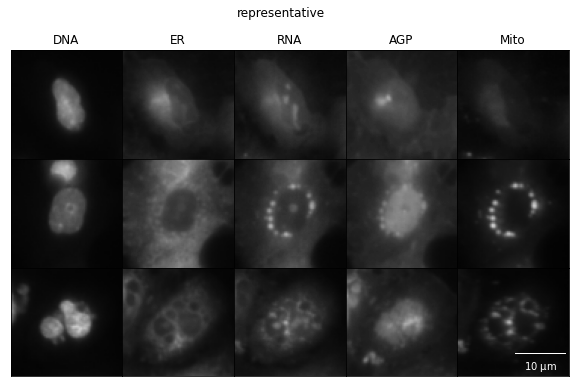

In [56]:
#@title Take a look at the images in a shuffled order, without the labels. 
#@markdown * Do you see any tendencies? Look at the nuclei size, intensity of the stains.

df_shuffle = df_plot.sample(frac=1).reset_index(drop=True)
fig_less_bias = visualize_n_SingleCell(channels, df_shuffle, box_size, title=plot, 
                                       image_width_column=image_width_column,
                                       filename_prefix=new_filename_prefix, 
                                       pathname_prefix="PathName_Orig",
                                       label=False,label_column=sort_by,
                                       compressed=compressed_images, 
                                       compressed_im_size=compressed_size, 
                                       correlation =True, 
                                       rescale=rescale_input_transf,
                                       scale_bar=True, pixel_size=pixel_size_int
                                      )

representative


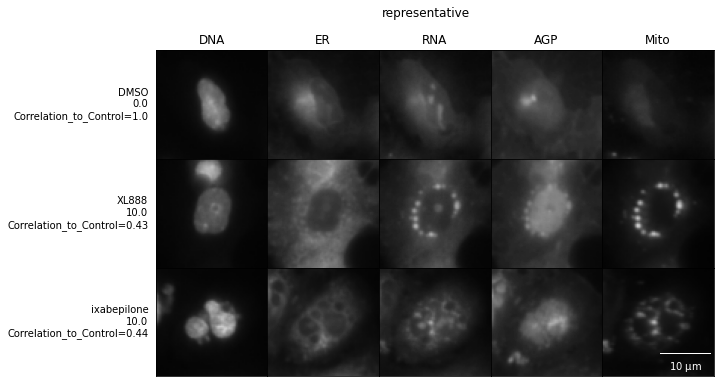

In [58]:
#@title Now look at the shuffled images with their labels. Can you think of any reasons why some cells are bigger, smaller?
fig_less_bias = visualize_n_SingleCell(channels, df_shuffle, box_size, title=plot, 
                                       image_width_column=image_width_column,
                             filename_prefix=new_filename_prefix, 
                             pathname_prefix="PathName_Orig",
                             label=True,label_column=sort_by,
                             compressed=compressed_images, 
                             compressed_im_size=compressed_size,
                             correlation =True, 
                             rescale=rescale_input_transf,
                             scale_bar=True, pixel_size=pixel_size_int)

## **6.2 Plot single cell based on method chosen in 6 (random or representative)**

representative


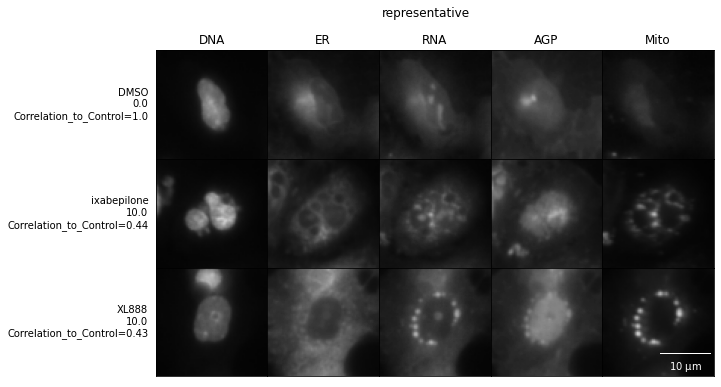

In [60]:
#@title Plot single-cells order by correlation
fig = visualize_n_SingleCell(channels, df_plot, box_size, title=plot, 
                             image_width_column=image_width_column,
                             filename_prefix=new_filename_prefix,
                             pathname_prefix="PathName_Orig",
                             label=True,label_column=sort_by,
                             compressed=compressed_images, 
                             compressed_im_size=compressed_size, 
                             correlation =True, 
                             rescale=rescale_input_transf,
                             scale_bar=True, pixel_size=pixel_size_int
                             )

In [ ]:
#@title Save image
fname = input("Give this figure a name:")
img_format = ".png"
fig.savefig(fname+img_format, dpi = 200, bbox_inches='tight')
files.download(fname+img_format)

Give this figure a name:Fig6_representative


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#@title Plot single-cells order by name
df_order = df_plot.sort_values(by=sort_by).reset_index()
fig = visualize_n_SingleCell(channels, df_order, box_size, title=plot, 
                             image_width_column=image_width_column_input,
                             filename_prefix=filename_col_prefix_input,
                             pathname_prefix="PathName_Orig",
                             label=True,label_column=sort_by,
                             compressed=compressed_images, 
                             compressed_im_size=compressed_size, 
                             correlation=False, 
                             rescale=rescale_input_transf,
                             scale_bar=True, pixel_size=pixel_size_int
                             )

## **6.3 Plot images where cells above (section 6.2) are located**

- Visualize an entire representative field of view

representative


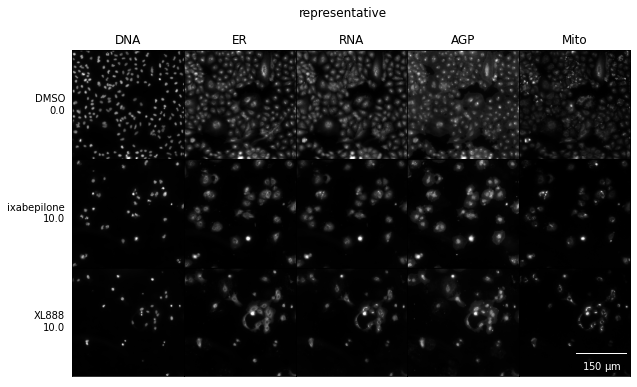

In [61]:
#@title Plot images
img = visualize_image(channels, df_plot, title=plot, 
                      filename_prefix=new_filename_prefix, 
                      pathname_prefix="PathName_Orig",
                      label=True, label_column=sort_by,
                      rescale=rescale_input_transf,
                      scale_bar=True, pixel_size=pixel_size_int
                      )

In [ ]:
#@title Save image
fname = input("Give this figure a name:")
img_format = ".png"
img.savefig(fname+img_format, dpi = 200, bbox_inches='tight')
files.download(fname+img_format)

Give this figure a name:Fig6_representativeimage


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#@title # **7. Export the representative cells dataframe**
#@markdown For reproducibility purposes, if you want to plot these images again later, export the dataframe with the selected cells as a CSV file.
output_file = input('Provide a filename for the output file: ')
df_plot.to_csv(output_file + ".csv")
files.download(output_file + ".csv")